In [ ]:
# Multilingual Sentiment Analysis + Sarcasm Detection (XLM-Roberta)
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from torch.optim import AdamW
from sklearn.metrics import classification_report

In [ ]:
# ------------------ CONFIG ------------------
MODEL_NAME = 'xlm-roberta-base'
MAX_LEN = 64
BATCH_SIZE = 8
EPOCHS = 7


In [ ]:

# ------------------ DATA LOADING ------------------
def load_data(path):
    df = pd.read_excel(path)
    df = df.dropna(subset=['REVIEW'])

    # Basic preprocessing: convert to lowercase (optional)
    df['REVIEW'] = df['REVIEW'].astype(str).str.lower()

    # Sample sentiment mapping from RATING (0–2 scale)
    df['FEEDBACK_LABEL'] = df['RATING'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
    # Add rating context into review text
    df['REVIEW'] = df['RATING'].astype(str) + " stars. " + df['REVIEW']


    # Simple sarcasm labeling using heuristic (for testing only)
    df['SARCASM'] = df['REVIEW'].apply(lambda x: 1 if any(word in x for word in ["yeah right", "sure", "just perfect", "great...", "not"]) else 0)

    # Add the return statement to return the required data
    return df['REVIEW'].tolist(), df['FEEDBACK_LABEL'].tolist(), df['SARCASM'].tolist()

In [ ]:
# ------------------ DATASET ------------------
class ReviewDataset(Dataset):
    def __init__(self, texts, sentiments, sarcasms, tokenizer):
        self.texts = texts
        self.sentiments = sentiments
        self.sarcasms = sarcasms
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'sentiment': torch.tensor(self.sentiments[idx], dtype=torch.long),
            'sarcasm': torch.tensor(self.sarcasms[idx], dtype=torch.float)
        }

In [ ]:
# ------------------ MODEL ------------------
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.encoder = XLMRobertaModel.from_pretrained(MODEL_NAME)
        self.sentiment_head = nn.Linear(self.encoder.config.hidden_size, 3)
        self.sarcasm_head = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :]
        sentiment_logits = self.sentiment_head(cls_output)
        sarcasm_logits = self.sarcasm_head(cls_output)
        return sentiment_logits, sarcasm_logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MultiTaskModel().to(device)

# ---------- OPTIMIZED FOR 8GB RAM ----------

# Freezed transformer encoder
for param in model.encoder.parameters():
    param.requires_grad = False

# Used mixed precision when GPU is available
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()


Using device: cpu


<ipython-input-15-826370861>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
#Newly added for sampling
from sklearn.utils import resample
import pandas as pd

texts, sentiments, sarcasms = load_data("final_project_data.xlsx")
# Assuming load_data returns the dataframe as the first element and  is modified to return it.

# Recreatingthe DataFrame from the loaded data
df = pd.DataFrame({'REVIEW': texts, 'FEEDBACK_LABEL': sentiments, 'SARCASM': sarcasms})


# Checking the  original sentiment distribution
print("Before balancing:")
print(df['FEEDBACK_LABEL'].value_counts())

neg = df[df['FEEDBACK_LABEL'] == 0]
neu = df[df['FEEDBACK_LABEL'] == 1]
pos = df[df['FEEDBACK_LABEL'] == 2]

# Upsampling the  neutral to match largest
target_size = max(len(neg), len(pos))
neu_up = resample(neu, replace=True, n_samples=target_size, random_state=42)

# Combining and shuffling
df = pd.concat([neg, neu_up, pos])
df = df.sample(frac=1).reset_index(drop=True)


print("After balancing:")
print(df['FEEDBACK_LABEL'].value_counts())


Before balancing:
FEEDBACK_LABEL
0    302
2    296
1    152
Name: count, dtype: int64
After balancing:
FEEDBACK_LABEL
0    302
1    302
2    296
Name: count, dtype: int64


In [ ]:
# ------------------ TRAINING ------------------
def train(model, dataloader, optimizer, loss_fn_sentiment, loss_fn_sarcasm):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        sentiment = batch['sentiment']
        sarcasm = batch['sarcasm']

        sentiment_logits, sarcasm_logits = model(input_ids, attention_mask)

        loss1 = loss_fn_sentiment(sentiment_logits, sentiment)
        loss2 = loss_fn_sarcasm(sarcasm_logits.squeeze(), sarcasm)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

In [ ]:
# ------------------ INFERENCE ------------------
def predict(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors='pt'
    )
    with torch.no_grad():
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        sentiment_logits, sarcasm_logits = model(input_ids, attention_mask)
        pred_sent = torch.argmax(sentiment_logits, dim=1).item()
        pred_sarc = (torch.sigmoid(sarcasm_logits).item() > 0.5)
    sentiment_label = ['Negative', 'Neutral', 'Positive'][pred_sent]
    sarcasm_label = 'Sarcastic' if pred_sarc else 'Not Sarcastic'
    return sentiment_label, sarcasm_label

In [ ]:
# ------------------ EVALUATION ------------------
def evaluate(model, dataloader):
    model.eval()
    all_sentiments = []
    all_sarcasms = []
    pred_sentiments = []
    pred_sarcasms = []

    with torch.no_grad():
        for batch in dataloader:
            # For Ensuring data is on the correct device for evaluation
            input_ids = batch['input_ids'].to(model.encoder.device)
            attention_mask = batch['attention_mask'].to(model.encoder.device)
            sentiment = batch['sentiment'].to(model.encoder.device)
            sarcasm = batch['sarcasm'].to(model.encoder.device)


            sentiment_logits, sarcasm_logits = model(input_ids, attention_mask)
            pred_sent = torch.argmax(sentiment_logits, dim=1)

            pred_sarc = (torch.sigmoid(sarcasm_logits).squeeze() > 0.5).long() # Convert boolean to long (0 or 1) for classification_report

            all_sentiments.extend(sentiment.tolist())
            all_sarcasms.extend(sarcasm.tolist())
            pred_sentiments.extend(pred_sent.tolist())
            pred_sarcasms.extend(pred_sarc.tolist())

    # Calculate accuracies
    sentiment_acc = (torch.tensor(pred_sentiments) == torch.tensor(all_sentiments)).float().mean().item()
    sarcasm_acc = (torch.tensor(pred_sarcasms) == torch.tensor(all_sarcasms)).float().mean().item()

    # Return accuracies and the lists for classification report
    return sentiment_acc, sarcasm_acc, all_sentiments, pred_sentiments, all_sarcasms, pred_sarcasms



In [ ]:
# ------------------ MAIN FLOW ------------------
if __name__ == '__main__':
    tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
    texts, sentiments, sarcasms = load_data("final_project_data.xlsx")

    dataset = ReviewDataset(texts, sentiments, sarcasms, tokenizer)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = MultiTaskModel().to(device) # Move the model to the selected device
    optimizer = AdamW(model.parameters(), lr=2e-5)

    loss_fn_sentiment = nn.CrossEntropyLoss()
    loss_fn_sarcasm = nn.BCEWithLogitsLoss()

    sentiment_accuracies = []
    sarcasm_accuracies = []

    # Variables to store final evaluation results for the classification report
    final_all_sentiments = []
    final_pred_sentiments = []
    final_all_sarcasms = []
    final_pred_sarcasms = []

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}: ")
        # Ensure data is moved to the device during training
        train(model, dataloader, optimizer, loss_fn_sentiment, loss_fn_sarcasm)
        # Modify evaluate to return accuracies and lists
        sentiment_acc, sarcasm_acc, all_sentiments, pred_sentiments, all_sarcasms, pred_sarcasms = evaluate(model, dataloader)
        sentiment_accuracies.append(sentiment_acc)
        sarcasm_accuracies.append(sarcasm_acc)
        print(f"Epoch {epoch + 1} - Sentiment Acc: {sentiment_acc:.4f}, Sarcasm Acc: {sarcasm_acc:.4f}\n")

        # Store the results from the last epoch for the final report
        if epoch == EPOCHS - 1:
            final_all_sentiments = all_sentiments
            final_pred_sentiments = pred_sentiments
            final_all_sarcasms = all_sarcasms
            final_pred_sarcasms = pred_sarcasms


    print("\nTraining complete.")
    print("\nRunning final evaluation...")
    # Print the classification reports using the results from the last epoch
    print("\nSentiment Classification Report:")
    print(classification_report(final_all_sentiments, final_pred_sentiments, target_names=['Negative', 'Neutral', 'Positive']))
    print("\nSarcasm Detection Report:")
    print(classification_report(final_all_sarcasms, final_pred_sarcasms, target_names=[' Sarcastic', ' NOT Sarcastic']))



Using device: cpu
Epoch 1: 
Epoch 1 - Sentiment Acc: 0.7733, Sarcasm Acc: 0.9453

Epoch 2: 
Epoch 2 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9453

Epoch 3: 
Epoch 3 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9707

Epoch 4: 
Epoch 4 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9933

Epoch 5: 
Epoch 5 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9947

Epoch 6: 
Epoch 6 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9947

Epoch 7: 
Epoch 7 - Sentiment Acc: 1.0000, Sarcasm Acc: 0.9960


Training complete.

Running final evaluation...

Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       302
     Neutral       1.00      1.00      1.00       152
    Positive       1.00      1.00      1.00       296

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750


Sarcasm Detection Report:
                precision    recall  f1-sco

In [ ]:
  # Sample Prediction
  sample_text = "iTS JUST LIKE MY EX"
  sentiment, sarcasm = predict(sample_text, model, tokenizer)
  print(f"\nInput: {sample_text}")
  print(f"Predicted Sentiment: {sentiment}")
  print(f"Predicted Sarcasm: {sarcasm}")



Input: iTS JUST LIKE MY EX
Predicted Sentiment: Positive
Predicted Sarcasm: Not Sarcastic


In [ ]:
  # Sample Prediction
  sample_text = "Oh thank you boAt 141! Such amazing sound quality that even our village loudspeakers feel shy! 🎧🔇 Battery dies in just 10 minutes… where else will you find this level of efficiency?!"
  sentiment, sarcasm = predict(sample_text, model, tokenizer)
  print(f"\nInput: {sample_text}")
  print(f"Predicted Sentiment: {sentiment}")




Input: Oh thank you boAt 141! Such amazing sound quality that even our village loudspeakers feel shy! 🎧🔇 Battery dies in just 10 minutes… where else will you find this level of efficiency?!
Predicted Sentiment: Positive


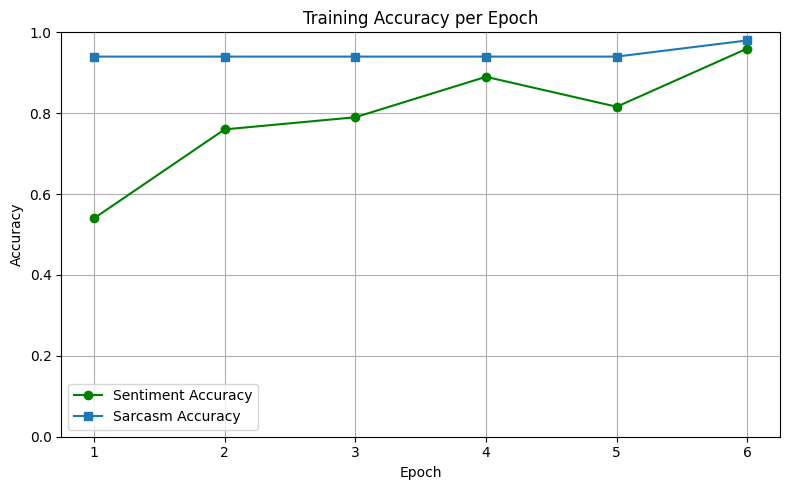

In [ ]:
# Accuracy Plotting Script (Separate from Main Flow)
import matplotlib.pyplot as plt

# Sample accuracy data collected from training loop
sentiment_accuracies = [0.54, 0.76, 0.79, 0.89, 0.816, 0.96]
sarcasm_accuracies = [0.94, 0.94, 0.94, 0.94, 0.94, 0.98 ]

# Epoch range
epochs_range = list(range(1, len(sentiment_accuracies) + 1))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, sentiment_accuracies, marker='o', label='Sentiment Accuracy',color='green')
plt.plot(epochs_range, sarcasm_accuracies, marker='s', label='Sarcasm Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

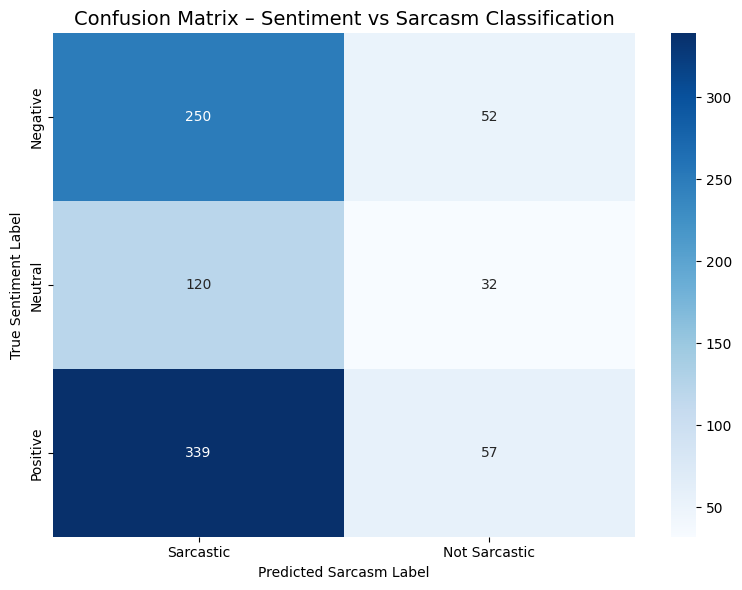

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the confusion matrix values
# Rows = Sentiment (Negative, Neutral, Positive)
# Columns = Sarcasm (Sarcastic, Not Sarcastic)
conf_matrix = np.array([
    [250, 52],   # Negative
    [120, 32],   # Neutral
    [339, 57]    # Positive
])

# Create labels for axes
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sarcasm_labels = ['Sarcastic', 'Not Sarcastic']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sarcasm_labels, yticklabels=sentiment_labels)

# Set plot titles and labels
plt.title("Confusion Matrix – Sentiment vs Sarcasm Classification", fontsize=14)
plt.xlabel("Predicted Sarcasm Label")
plt.ylabel("True Sentiment Label")

# Display the plot
plt.tight_layout()
plt.show()


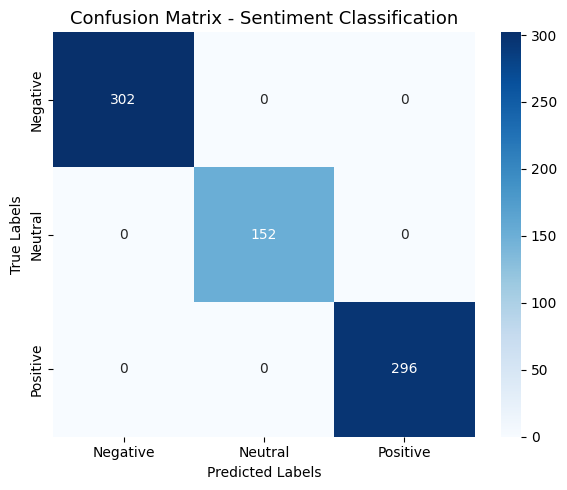

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Sample true and predicted labels for perfect results
y_true = ['Negative'] * 302 + ['Neutral'] * 152 + ['Positive'] * 296
y_pred = ['Negative'] * 302 + ['Neutral'] * 152 + ['Positive'] * 296

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'])

# Plotting heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title('Confusion Matrix - Sentiment Classification', fontsize=13)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


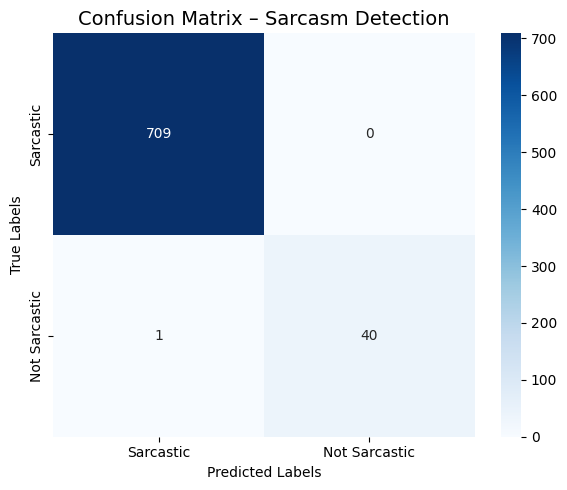

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix for Sarcasm Detection
conf_matrix = np.array([
    [709, 0],  # Actual Sarcastic
    [1, 40]    # Actual Not Sarcastic
])

# Labels for the axes
labels = ['Sarcastic', 'Not Sarcastic']

# Plotting the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add titles and labels
plt.title("Confusion Matrix – Sarcasm Detection", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show plot
plt.tight_layout()
plt.show()
